In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_st as rrnn
import model_confs as confs

import singletask_dep as st
import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
encoding_type = 'relative'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_train_token,task,eval=False,deps=True)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskSimple(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# ABOUT

In [15]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [16]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_about'

In [17]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5089285714285714 

Using scikit learn accuracy por género en el conjunto about
MALE 0.0026041666666666665
FEMALE 0.995 

GLOBAL: 0.47853535353535354 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0024330900243309003
FEMALE 0.9921259842519685 

GLOBAL: 0.48891786179921776 

Using scikit learn accuracy por género en el conjunto as
MALE 0.017676767676767676
FEMALE 0.9919137466307277 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6923768270098789 	 Validation loss: 0.6901852064213511 	 
  1%|          | 574/57400 [00:05<07:33, 125.29it/s]
Epoch 2 	 Training loss: 0.68775805031381 	 Validation loss: 0.6872485300241891 	 
  2%|▏         | 1148/57400 [00:10<07:14, 129.60it/s]
Epoch 3 	 Training loss: 0.6849906976214685 	 Validation loss: 0.6856747067580788 	 
  3%|▎         | 1722/57400 [00:15<07:31, 123.36it/s]
Epoch 4 	 Training loss: 0.6834228711676514 	 Validation loss: 0.6847888190867537 	 
  4%|▍         | 2296/57400 [00:20<08:02, 114.11it/s]
Epoch 5 	 Training loss: 0.6824881047114263 	 Validation loss: 0.6843290238057153 	 
  5%|▌         | 2870/57400 [00:25<07:03, 128.72it/s]
Epoch 6 	 Training loss: 0.6819253564919329 	 Validation loss: 0.6840118452654047 	 
  6%|▌         | 3444/57400 [00:30<07:00, 128.24it/s]
Epoch 7 	 Training loss: 0.6816793024955311 	 Validation loss: 0.6839667498055151 	 
  7%|▋         | 4018/57400 [00:35<06:47, 130.84it/s]
Epoch 8 	 Training loss: 0.681

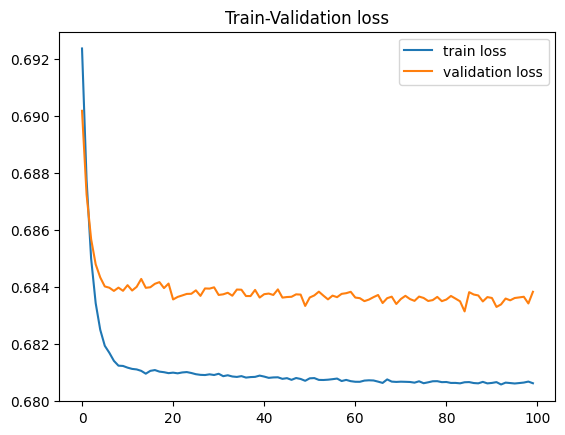

In [18]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [19]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4897959183673469 

Using scikit learn accuracy por género en el conjunto about
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.5189393939393939 

Using scikit learn accuracy por género en el conjunto to
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.516297262059974 

Using scikit learn accuracy por género en el conjunto as
MALE 1.0
FEMALE 0.0 



# TO

In [20]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [21]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_to'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931699529965165 	 Validation loss: 0.6931737691669141 	 
  1%|          | 574/57400 [00:05<08:25, 112.48it/s]
Epoch 2 	 Training loss: 0.6931963152794057 	 Validation loss: 0.6933034799866757 	 
  2%|▏         | 1148/57400 [00:11<08:00, 116.98it/s]
Epoch 3 	 Training loss: 0.6931341537615148 	 Validation loss: 0.6931719153614367 	 
  3%|▎         | 1722/57400 [00:16<08:27, 109.78it/s]
Epoch 4 	 Training loss: 0.6931741263600592 	 Validation loss: 0.6930948415045011 	 
  4%|▍         | 2296/57400 [00:22<07:57, 115.42it/s]
Epoch 5 	 Training loss: 0.6931868549631033 	 Validation loss: 0.6929509831687152 	 
  5%|▌         | 2870/57400 [00:27<07:54, 114.92it/s]
Epoch 6 	 Training loss: 0.6931345984080112 	 Validation loss: 0.6929586095325018 	 
  6%|▌         | 3444/57400 [00:32<07:49, 114.94it/s]
Epoch 7 	 Training loss: 0.6931590761872534 	 Validation loss: 0.6930618084083169 	 
  7%|▋         | 4018/57400 [00:38<07:41, 115.57it/s]
Epoch 8 	 Training loss: 0.6

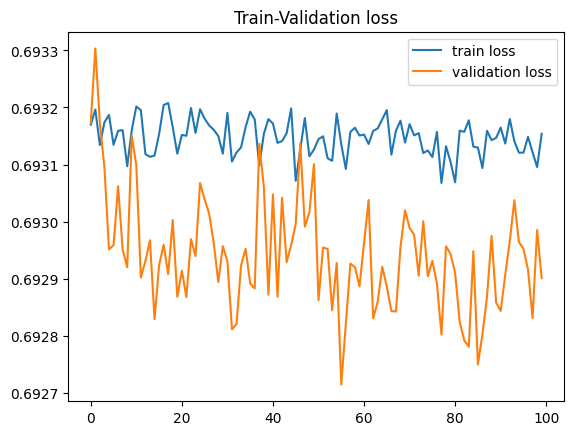

In [22]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [23]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5076530612244898 

Using scikit learn accuracy por género en el conjunto about
MALE 0.4010416666666667
FEMALE 0.61 

GLOBAL: 0.46085858585858586 

Using scikit learn accuracy por género en el conjunto to
MALE 0.35036496350364965
FEMALE 0.5800524934383202 

GLOBAL: 0.4876140808344198 

Using scikit learn accuracy por género en el conjunto as
MALE 0.398989898989899
FEMALE 0.5822102425876011 



# AS

In [24]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_as'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6935924434911084 	 Validation loss: 0.6942368574061636 	 
  1%|          | 574/57400 [00:05<08:14, 115.01it/s]
Epoch 2 	 Training loss: 0.6934035759977347 	 Validation loss: 0.6938163294630536 	 
  2%|▏         | 1148/57400 [00:11<08:03, 116.23it/s]
Epoch 3 	 Training loss: 0.6932255100290119 	 Validation loss: 0.6937568157406176 	 
  3%|▎         | 1722/57400 [00:16<08:11, 113.25it/s]
Epoch 4 	 Training loss: 0.693231847539596 	 Validation loss: 0.6936204150571661 	 
  4%|▍         | 2296/57400 [00:21<08:00, 114.70it/s]
Epoch 5 	 Training loss: 0.6932618936802868 	 Validation loss: 0.6933143825854285 	 
  5%|▌         | 2870/57400 [00:27<07:52, 115.36it/s]
Epoch 6 	 Training loss: 0.6932359154008407 	 Validation loss: 0.6933569059533587 	 
  6%|▌         | 3444/57400 [00:32<07:47, 115.35it/s]
Epoch 7 	 Training loss: 0.6931791036594205 	 Validation loss: 0.6933487774962086 	 
  7%|▋         | 4018/57400 [00:38<07:46, 114.39it/s]
Epoch 8 	 Training loss: 0.69

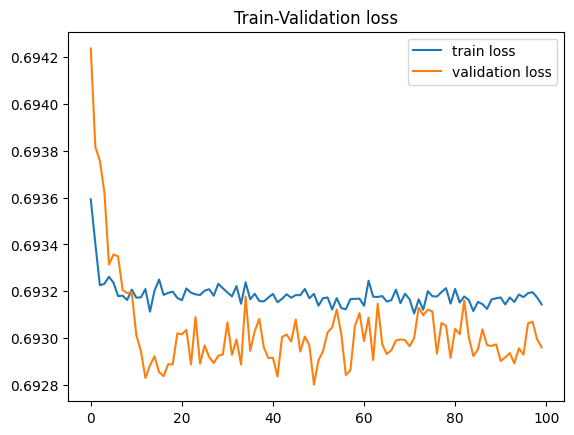

In [25]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [26]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.47066326530612246 

Using scikit learn accuracy por género en el conjunto about
MALE 0.23958333333333334
FEMALE 0.6925 

GLOBAL: 0.4962121212121212 

Using scikit learn accuracy por género en el conjunto to
MALE 0.2846715328467153
FEMALE 0.7244094488188977 

GLOBAL: 0.500651890482399 

Using scikit learn accuracy por género en el conjunto as
MALE 0.3207070707070707
FEMALE 0.692722371967655 



# ADAM

In [27]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_about_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6809782056650634 	 Validation loss: 0.6810548558073529 	 
  1%|          | 574/57400 [00:05<08:18, 113.93it/s]
Epoch 2 	 Training loss: 0.6712627804445472 	 Validation loss: 0.6637479258795916 	 
  2%|▏         | 1148/57400 [00:11<08:31, 110.03it/s]
Epoch 3 	 Training loss: 0.6567669498380468 	 Validation loss: 0.6538698471198647 	 
  3%|▎         | 1722/57400 [00:16<08:15, 112.39it/s]
Epoch 4 	 Training loss: 0.6463850816575493 	 Validation loss: 0.6447452912896366 	 
  4%|▍         | 2296/57400 [00:22<08:06, 113.36it/s]
Epoch 5 	 Training loss: 0.635837810483959 	 Validation loss: 0.6381012241719133 	 
  5%|▌         | 2870/57400 [00:27<07:57, 114.17it/s]
Epoch 6 	 Training loss: 0.6260468297303762 	 Validation loss: 0.6278110570826773 	 
  6%|▌         | 3444/57400 [00:33<07:55, 113.42it/s]
Epoch 7 	 Training loss: 0.6167953104715314 	 Validation loss: 0.6208241874888792 	 
  7%|▋         | 4018/57400 [00:38<07:56, 112.01it/s]
Epoch 8 	 Training loss: 0.60

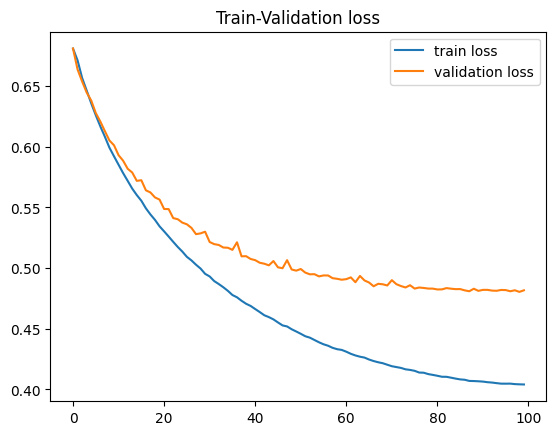

In [28]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [29]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.7219387755102041 

Using scikit learn accuracy por género en el conjunto about
MALE 0.734375
FEMALE 0.71 

GLOBAL: 0.5517676767676768 

Using scikit learn accuracy por género en el conjunto to
MALE 0.5498783454987834
FEMALE 0.5538057742782152 

GLOBAL: 0.5893089960886571 

Using scikit learn accuracy por género en el conjunto as
MALE 0.5858585858585859
FEMALE 0.5929919137466307 



# TO

In [30]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_to_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933400042173339 	 Validation loss: 0.6933552895562124 	 
  1%|          | 574/57400 [00:06<09:21, 101.28it/s]
Epoch 2 	 Training loss: 0.6932384535826042 	 Validation loss: 0.6929458490872787 	 
  2%|▏         | 1148/57400 [00:12<09:13, 101.64it/s]
Epoch 3 	 Training loss: 0.6932216726944421 	 Validation loss: 0.695017028663118 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:11, 101.01it/s]
Epoch 4 	 Training loss: 0.6931281885203584 	 Validation loss: 0.6930949324268406 	 
  4%|▍         | 2296/57400 [00:24<09:05, 100.97it/s]
Epoch 5 	 Training loss: 0.6930382758482824 	 Validation loss: 0.6931373557801974 	 
  5%|▌         | 2870/57400 [00:30<08:53, 102.19it/s]
Epoch 6 	 Training loss: 0.6931425002809185 	 Validation loss: 0.6932662715346126 	 
  6%|▌         | 3444/57400 [00:36<08:55, 100.79it/s]
Epoch 7 	 Training loss: 0.6930381107413395 	 Validation loss: 0.6922183996540004 	 
  7%|▋         | 4018/57400 [00:42<08:42, 102.24it/s]


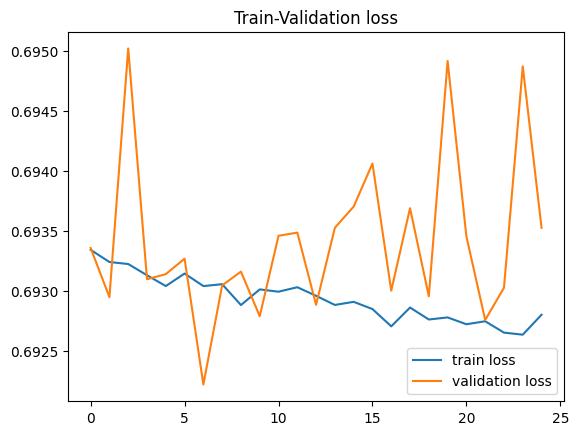

In [31]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [32]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5127551020408163 

Using scikit learn accuracy por género en el conjunto about
MALE 0.010416666666666666
FEMALE 0.995 

GLOBAL: 0.48358585858585856 

Using scikit learn accuracy por género en el conjunto to
MALE 0.014598540145985401
FEMALE 0.989501312335958 

GLOBAL: 0.4915254237288136 

Using scikit learn accuracy por género en el conjunto as
MALE 0.017676767676767676
FEMALE 0.9973045822102425 



# AS

In [33]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_as_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933187162211548 	 Validation loss: 0.6932048009613813 	 
  1%|          | 574/57400 [00:06<09:28, 99.99it/s]
Epoch 2 	 Training loss: 0.693203477078614 	 Validation loss: 0.6924702464523962 	 
  2%|▏         | 1148/57400 [00:12<09:14, 101.51it/s]
Epoch 3 	 Training loss: 0.6930782697341998 	 Validation loss: 0.6935894297341169 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:12, 100.69it/s]
Epoch 4 	 Training loss: 0.6931371632768717 	 Validation loss: 0.6932095541792401 	 
  4%|▍         | 2296/57400 [00:24<09:22, 97.96it/s]
Epoch 5 	 Training loss: 0.6930237259806656 	 Validation loss: 0.6931623068906493 	 
  5%|▌         | 2870/57400 [00:30<08:58, 101.24it/s]
Epoch 6 	 Training loss: 0.6929507184942425 	 Validation loss: 0.6931551412000494 	 
  6%|▌         | 3444/57400 [00:36<08:54, 100.88it/s]
Epoch 7 	 Training loss: 0.6930222103196985 	 Validation loss: 0.6931148403781956 	 
  7%|▋         | 4018/57400 [00:43<09:01, 98.62it/s]
Epo

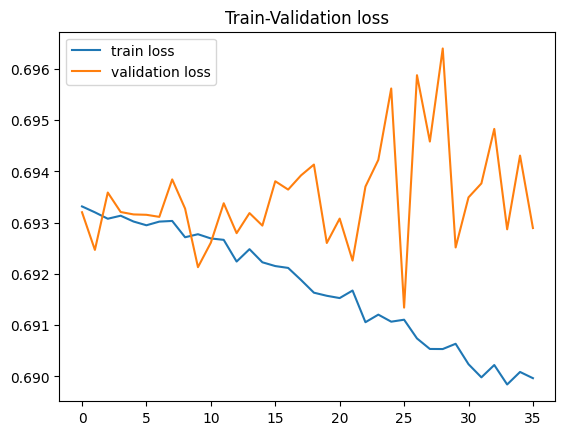

In [34]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [35]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4923469387755102 

Using scikit learn accuracy por género en el conjunto about
MALE 0.3307291666666667
FEMALE 0.6475 

GLOBAL: 0.5202020202020202 

Using scikit learn accuracy por género en el conjunto to
MALE 0.3381995133819951
FEMALE 0.7165354330708661 

GLOBAL: 0.5254237288135594 

Using scikit learn accuracy por género en el conjunto as
MALE 0.29797979797979796
FEMALE 0.7681940700808625 

